In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:
months = ['January', 'February', 'March', 'April', 'October', 'November', 'December']

In [3]:
acc = list()

In [4]:
f1 = list()

In [5]:
err = list()

In [6]:
house_data = pd.read_csv("../preprocessed_data/std_test_data_1faa36208e696350ee3ca80197c773f062678051.csv")

In [7]:
house_data.head()

,index,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,Month,DayOfWeek,HourofDay,Day,T_ctrl,T_stp_heat,Humidity,auxHeat1,fan,Thermostat_Temperature,T_out,RH_out
0,0,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.173227,-1.11864,0.818161,0,3,0.565131,0.185707,1.760278
1,1,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.173227,-1.11864,0.946499,0,17,0.565131,0.185707,1.760278
2,2,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.173227,-1.11864,0.946499,0,0,0.565131,0.185707,1.760278
3,3,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.173227,-1.11864,0.946499,0,3,0.565131,0.185707,1.760278
4,4,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.173227,-1.11864,0.818161,0,17,0.565131,0.185707,1.760278


In [8]:
house_data.Month.value_counts()

12    8914
1     8695
11    8647
4     8622
5     8214
3     8188
6     5351
2     5181
10    1774
Name: Month, dtype: int64

In [9]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
cumulative_df = pd.DataFrame({"T_ctrl": [], 
                              "T_stp_heat": [], 
                              "T_out" : [], 
                              "RH_out" : [],
                              "auxHeat1" : []})

# January

In [11]:
working_df = house_data[house_data.Month == 1]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6951, 34) (6951, 21) (1738, 34) (1738, 21)


In [12]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
696/696 [==============================] - 2s 3ms/step - loss: 0.8943 - accuracy: 0.8596 - val_loss: 0.6805 - val_accuracy: 0.8832
Epoch 2/20
696/696 [==============================] - 2s 3ms/step - loss: 0.5458 - accuracy: 0.9015 - val_loss: 0.6110 - val_accuracy: 0.8901
Epoch 3/20
696/696 [==============================] - 2s 3ms/step - loss: 0.5146 - accuracy: 0.9062 - val_loss: 0.5839 - val_accuracy: 0.8924
Epoch 4/20
696/696 [==============================] - 2s 3ms/step - loss: 0.4960 - accuracy: 0.9085 - val_loss: 0.5759 - val_accuracy: 0.8970
Epoch 5/20
696/696 [==============================] - 2s 3ms/step - loss: 0.4875 - accuracy: 0.9085 - val_loss: 0.5823 - val_accuracy: 0.8890
Epoch 6/20
696/696 [==============================] - 2s 3ms/step - loss: 0.4781 - accuracy: 0.9101 - val_loss: 0.5789 - val_accuracy: 0.8964
Epoch 7/20
696/696 [==============================] - 2s 3ms/step - loss: 0.4703 - accuracy: 0.9101 - val_loss: 0.5664 - val_accuracy: 0.8953
Epoch 

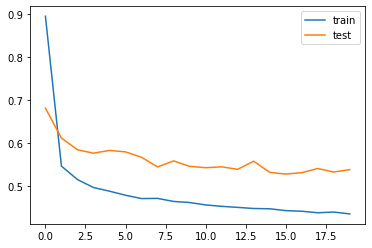

In [13]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

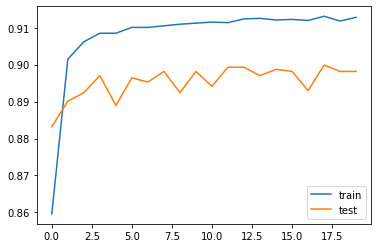

In [14]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [15]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

152775
154800
Error Percentage in predicted values is : 1.3254786450662739 %


In [16]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# February

In [17]:
working_df = house_data[house_data.Month == 2]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(11096, 34) (11096, 21) (2774, 34) (2774, 21)


In [18]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
1110/1110 [==============================] - 4s 4ms/step - loss: 0.7239 - accuracy: 0.8741 - val_loss: 0.5043 - val_accuracy: 0.9092
Epoch 2/20
1110/1110 [==============================] - 4s 3ms/step - loss: 0.4966 - accuracy: 0.9077 - val_loss: 0.4808 - val_accuracy: 0.9146
Epoch 3/20
1110/1110 [==============================] - 4s 3ms/step - loss: 0.4743 - accuracy: 0.9101 - val_loss: 0.4559 - val_accuracy: 0.9189
Epoch 4/20
1110/1110 [==============================] - 4s 3ms/step - loss: 0.4623 - accuracy: 0.9115 - val_loss: 0.4430 - val_accuracy: 0.9193
Epoch 5/20
1110/1110 [==============================] - 4s 3ms/step - loss: 0.4536 - accuracy: 0.9130 - val_loss: 0.4411 - val_accuracy: 0.9182
Epoch 6/20
1110/1110 [==============================] - 4s 3ms/step - loss: 0.4491 - accuracy: 0.9123 - val_loss: 0.4366 - val_accuracy: 0.9203
Epoch 7/20
1110/1110 [==============================] - 4s 3ms/step - loss: 0.4433 - accuracy: 0.9134 - val_loss: 0.4242 - val_accuracy:

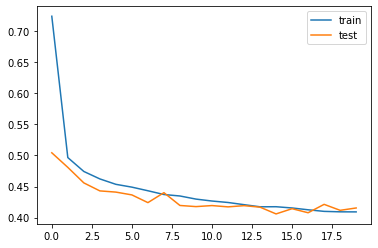

In [19]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

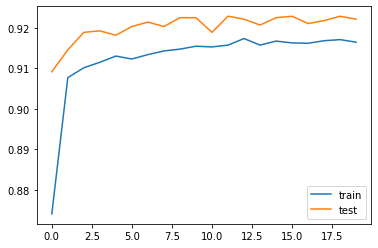

In [20]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [21]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

217800
217800
Error Percentage in predicted values is : 0.0 %


In [22]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# March

In [23]:
working_df = house_data[house_data.Month == 3]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(17646, 34) (17646, 21) (4412, 34) (4412, 21)


In [24]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
1765/1765 [==============================] - 6s 3ms/step - loss: 0.6227 - accuracy: 0.8936 - val_loss: 0.4223 - val_accuracy: 0.9209
Epoch 2/20
1765/1765 [==============================] - 6s 3ms/step - loss: 0.4378 - accuracy: 0.9196 - val_loss: 0.4227 - val_accuracy: 0.9191
Epoch 3/20
1765/1765 [==============================] - 6s 3ms/step - loss: 0.4189 - accuracy: 0.9215 - val_loss: 0.3927 - val_accuracy: 0.9234
Epoch 4/20
1765/1765 [==============================] - 5s 3ms/step - loss: 0.4076 - accuracy: 0.9222 - val_loss: 0.3795 - val_accuracy: 0.9266
Epoch 5/20
1765/1765 [==============================] - 6s 3ms/step - loss: 0.4019 - accuracy: 0.9228 - val_loss: 0.3792 - val_accuracy: 0.9266
Epoch 6/20
1765/1765 [==============================] - 6s 3ms/step - loss: 0.3956 - accuracy: 0.9238 - val_loss: 0.3820 - val_accuracy: 0.9254
Epoch 7/20
1765/1765 [==============================] - 6s 3ms/step - loss: 0.3891 - accuracy: 0.9241 - val_loss: 0.3705 - val_accuracy:

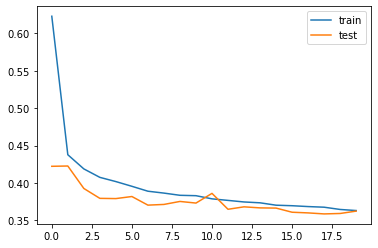

In [25]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

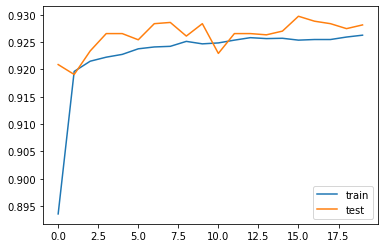

In [26]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [27]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

294885
298740
Error Percentage in predicted values is : 1.3072892822625768 %


In [28]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# April

In [29]:
working_df = house_data[house_data.Month == 4]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(24544, 34) (24544, 21) (6136, 34) (6136, 21)


In [30]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
2455/2455 [==============================] - 8s 3ms/step - loss: 0.5279 - accuracy: 0.9118 - val_loss: 0.3892 - val_accuracy: 0.9288
Epoch 2/20
2455/2455 [==============================] - 8s 3ms/step - loss: 0.3810 - accuracy: 0.9300 - val_loss: 0.3747 - val_accuracy: 0.9296
Epoch 3/20
2455/2455 [==============================] - 8s 3ms/step - loss: 0.3653 - accuracy: 0.9330 - val_loss: 0.3704 - val_accuracy: 0.9309
Epoch 4/20
2455/2455 [==============================] - 8s 3ms/step - loss: 0.3587 - accuracy: 0.9323 - val_loss: 0.3690 - val_accuracy: 0.9311
Epoch 5/20
2455/2455 [==============================] - 8s 3ms/step - loss: 0.3516 - accuracy: 0.9328 - val_loss: 0.3634 - val_accuracy: 0.9322
Epoch 6/20
2455/2455 [==============================] - 8s 3ms/step - loss: 0.3471 - accuracy: 0.9333 - val_loss: 0.3509 - val_accuracy: 0.9322
Epoch 7/20
2455/2455 [==============================] - 8s 3ms/step - loss: 0.3444 - accuracy: 0.9329 - val_loss: 0.3529 - val_accuracy:

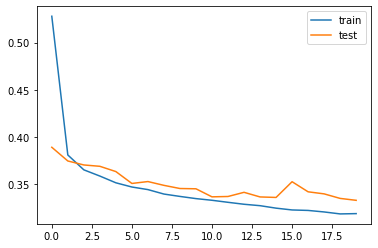

In [31]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

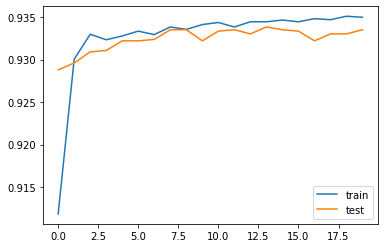

In [32]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [33]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

353340
358290
Error Percentage in predicted values is : 1.4009169638308712 %


In [34]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# October

In [35]:
working_df = house_data[house_data.Month == 10]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25963, 34) (25963, 21) (6491, 34) (6491, 21)


In [36]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
2597/2597 [==============================] - 8s 3ms/step - loss: 0.4884 - accuracy: 0.9183 - val_loss: 0.3744 - val_accuracy: 0.9311
Epoch 2/20
2597/2597 [==============================] - 9s 3ms/step - loss: 0.3653 - accuracy: 0.9332 - val_loss: 0.3516 - val_accuracy: 0.9345
Epoch 3/20
2597/2597 [==============================] - 8s 3ms/step - loss: 0.3517 - accuracy: 0.9345 - val_loss: 0.3460 - val_accuracy: 0.9353
Epoch 4/20
2597/2597 [==============================] - 8s 3ms/step - loss: 0.3421 - accuracy: 0.9362 - val_loss: 0.3416 - val_accuracy: 0.9364
Epoch 5/20
2597/2597 [==============================] - 8s 3ms/step - loss: 0.3354 - accuracy: 0.9367 - val_loss: 0.3292 - val_accuracy: 0.9362
Epoch 6/20
2597/2597 [==============================] - 8s 3ms/step - loss: 0.3292 - accuracy: 0.9373 - val_loss: 0.3363 - val_accuracy: 0.9359
Epoch 7/20
2597/2597 [==============================] - 8s 3ms/step - loss: 0.3264 - accuracy: 0.9366 - val_loss: 0.3274 - val_accuracy:

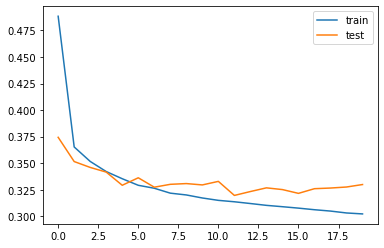

In [37]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

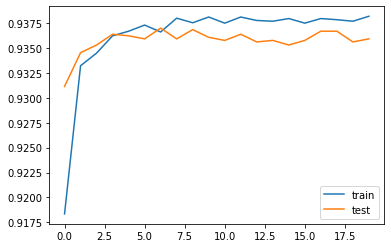

In [38]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [39]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

345990
353400
Error Percentage in predicted values is : 2.14168039538715 %


In [40]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9092795267630819

In [41]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [42]:
acc.append(max(history.history['accuracy']))

# November

In [43]:
working_df = house_data[house_data.Month == 11]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(32880, 34) (32880, 21) (8221, 34) (8221, 21)


In [44]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
3288/3288 [==============================] - 10s 3ms/step - loss: 0.4756 - accuracy: 0.9203 - val_loss: 0.3482 - val_accuracy: 0.9380
Epoch 2/20
3288/3288 [==============================] - 9s 3ms/step - loss: 0.3600 - accuracy: 0.9329 - val_loss: 0.3365 - val_accuracy: 0.9387
Epoch 3/20
3288/3288 [==============================] - 9s 3ms/step - loss: 0.3486 - accuracy: 0.9341 - val_loss: 0.3439 - val_accuracy: 0.9353
Epoch 4/20
3288/3288 [==============================] - 9s 3ms/step - loss: 0.3406 - accuracy: 0.9344 - val_loss: 0.3200 - val_accuracy: 0.9403
Epoch 5/20
3288/3288 [==============================] - 9s 3ms/step - loss: 0.3353 - accuracy: 0.9348 - val_loss: 0.3204 - val_accuracy: 0.9383
Epoch 6/20
3288/3288 [==============================] - 9s 3ms/step - loss: 0.3320 - accuracy: 0.9352 - val_loss: 0.3129 - val_accuracy: 0.9405
Epoch 7/20
3288/3288 [==============================] - 10s 3ms/step - loss: 0.3285 - accuracy: 0.9354 - val_loss: 0.3092 - val_accurac

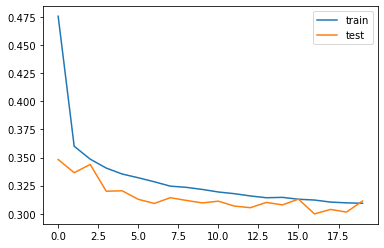

In [45]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

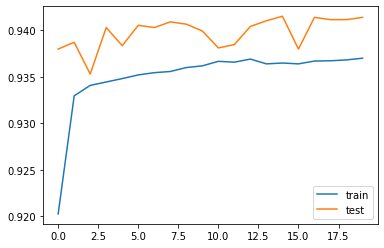

In [46]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [47]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

436740
431295
Error Percentage in predicted values is : 1.246737189174337 %


In [48]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9172925977459196

In [49]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [50]:
acc.append(max(history.history['accuracy']))

# December

In [51]:
working_df = house_data[house_data.Month == 12]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40012, 34) (40012, 21) (10003, 34) (10003, 21)


In [52]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
4002/4002 [==============================] - 13s 3ms/step - loss: 0.4543 - accuracy: 0.9244 - val_loss: 0.3814 - val_accuracy: 0.9327
Epoch 2/20
4002/4002 [==============================] - 13s 3ms/step - loss: 0.3539 - accuracy: 0.9350 - val_loss: 0.3558 - val_accuracy: 0.9332
Epoch 3/20
4002/4002 [==============================] - 12s 3ms/step - loss: 0.3399 - accuracy: 0.9359 - val_loss: 0.3709 - val_accuracy: 0.9296
Epoch 4/20
4002/4002 [==============================] - 14s 3ms/step - loss: 0.3336 - accuracy: 0.9360 - val_loss: 0.3431 - val_accuracy: 0.9335
Epoch 5/20
4002/4002 [==============================] - 13s 3ms/step - loss: 0.3299 - accuracy: 0.9365 - val_loss: 0.3506 - val_accuracy: 0.9332
Epoch 6/20
4002/4002 [==============================] - 12s 3ms/step - loss: 0.3276 - accuracy: 0.9365 - val_loss: 0.3441 - val_accuracy: 0.9335
Epoch 7/20
4002/4002 [==============================] - 12s 3ms/step - loss: 0.3247 - accuracy: 0.9361 - val_loss: 0.3389 - val_ac

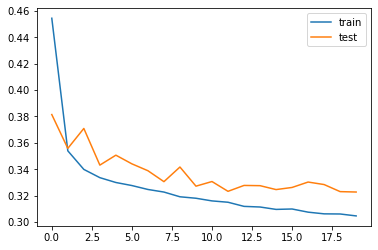

In [53]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

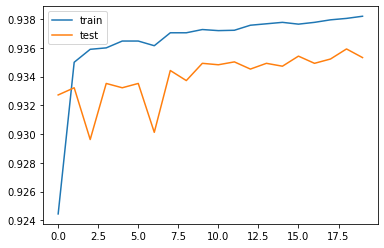

In [54]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [55]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

531840
535740
Error Percentage in predicted values is : 0.7333032490974729 %


In [56]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9090337524824056

In [57]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [58]:
acc.append(max(history.history['accuracy']))

[Text(0, 0.5, 'Weighted F1-Score'), Text(0.5, 0, 'Data Upto & Including')]

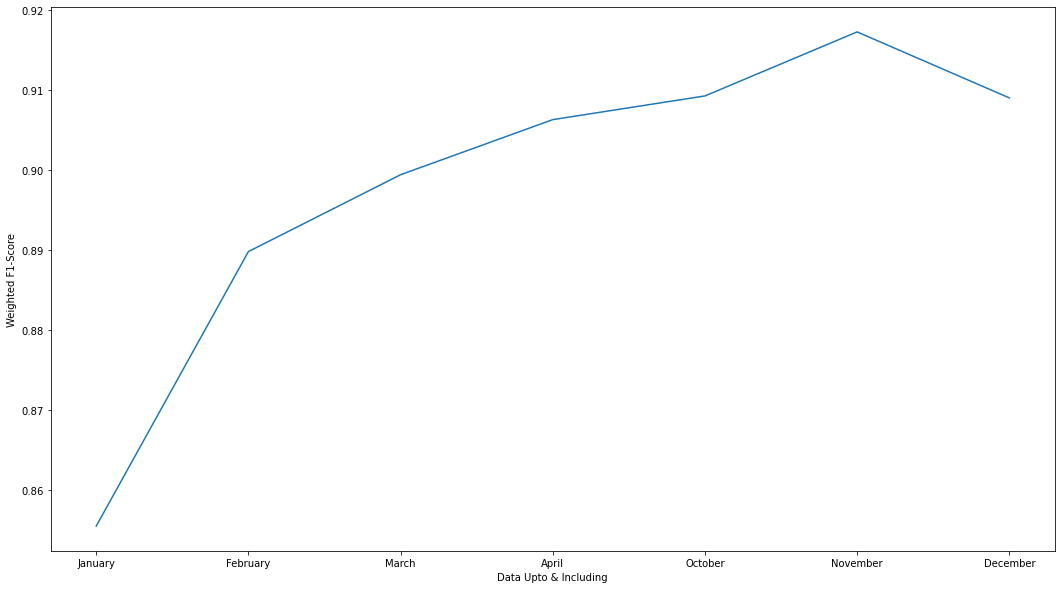

In [59]:
plt.figure(figsize = (18, 10))
ax = sns.lineplot(x = months, y = f1, sort = False)
ax.set(xlabel = "Data Upto & Including", ylabel = "Weighted F1-Score")

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Data Upto & Including')]

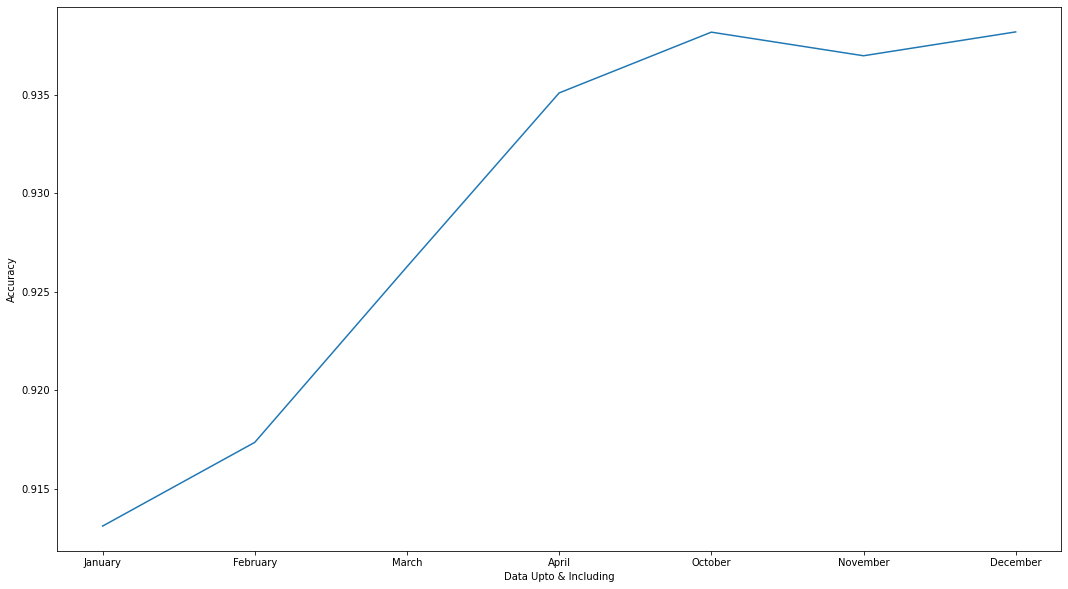

In [60]:
plt.figure(figsize = (18, 10))
ax = sns.lineplot(x = months, y = acc, sort = False)
ax.set(xlabel = "Data Upto & Including", ylabel = "Accuracy")

[Text(0, 0.5, 'Error % in Prediction'), Text(0.5, 0, 'Data Upto & Including')]

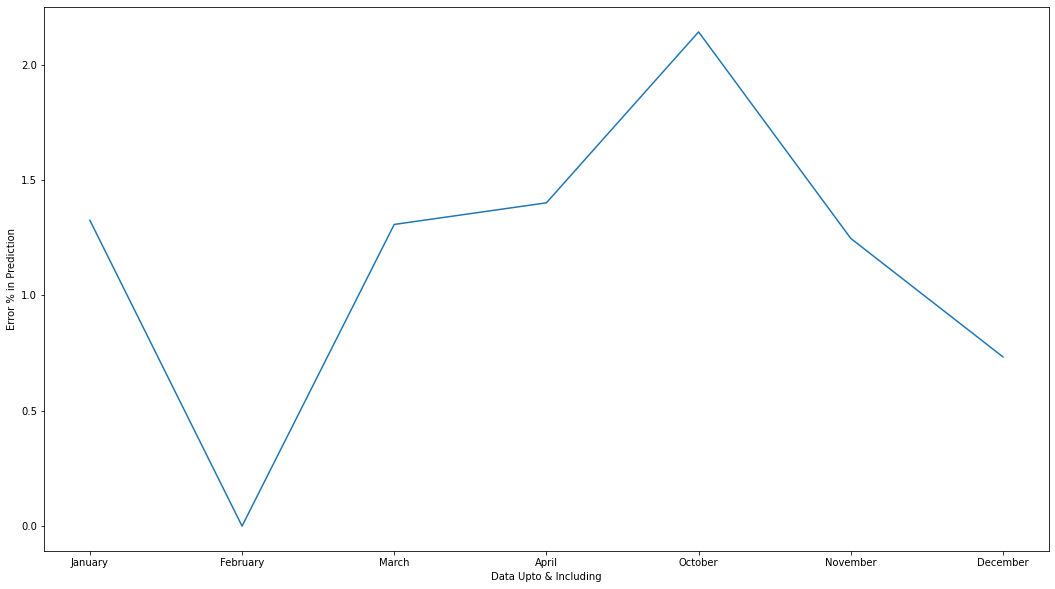

In [61]:
plt.figure(figsize = (18, 10))
ax = sns.lineplot(x = months, y = err, sort = False)
ax.set(xlabel = "Data Upto & Including", ylabel = "Error % in Prediction")